# Clustering and Anomaly Detection in Credit Card Fraud Data

### Problem: Credit Card Fraud Detection

**Credit card fraud detection** is the task of identifying illegitimate or unauthorized transactions made using a credit card. It is a major real-world problem for banks, financial institutions, and consumers due to:

* **Massive transaction volume** (millions per day)
* **Low fraud rate** (fraud cases are rare — typically <1%)
* **High financial and reputational risk** when fraud is not detected
* **Evolving tactics** — fraudsters constantly adapt their methods

---

## Challenges in Fraud Detection

| Challenge               | Description                                                                    |
| ----------------------- | ------------------------------------------------------------------------------ |
| **Class Imbalance**     | Fraud is extremely rare → imbalanced datasets (e.g., 0.2% fraud)               |
| **Concept Drift**       | Fraud patterns change over time                                                |
| **Real-time Detection** | Systems must react instantly to flag or block suspicious transactions          |
| **Feature Complexity**  | Transactions include time, amount, merchant, location, etc. (often anonymized) |
| **Cost of Errors**      | False positives → customer inconvenience; false negatives → financial loss     |

---

## Why Use Anomaly Detection?

**Anomaly detection** identifies rare or unusual patterns in data that do not conform to expected behavior.

In credit card fraud detection:

### **Anomalies = Potential Frauds**

| Legitimate Behavior      | Fraudulent Behavior                     |
| ------------------------ | --------------------------------------- |
| Regular purchase amounts | Sudden large or repeated small charges  |
| Usual merchant locations | Foreign transactions or risky merchants |
| Normal timing            | Unusual hour or frequency               |

---

## Goals of Anomaly Detection in Fraud Detection

1. **Detect fraud without needing labeled data** (unsupervised or semi-supervised methods)
2. **Model normal behavior** → anything that deviates is flagged
3. **Work with evolving patterns** without constant retraining

---

## Common Anomaly Detection Techniques Used

| Technique                      | Description                                                           |
| ------------------------------ | --------------------------------------------------------------------- |
| **Z-score**                    | Flags values that are far from the mean                               |
| **k-NN distance**              | Points with high average distance to neighbors are flagged            |
| **Local Outlier Factor (LOF)** | Compares local density around a point vs. neighbors                   |
| **Isolation Forest**           | Isolates anomalies by recursively splitting features                  |
| **Autoencoders**               | Neural networks that reconstruct normal patterns poorly for anomalies |

---

## Anomaly Detection vs. Classification

| Criteria           | Supervised Classification | Anomaly Detection                   |
| ------------------ | ------------------------- | ----------------------------------- |
| Requires labels    |  Yes                     |  No or few required                |
| Handles imbalance  |  Hard without sampling  |  Naturally suited for imbalance    |
| Works in real-time |  With retraining         |  Good for streaming applications   |
| Adaptability       |  Static                  |  Better for evolving fraud tactics |

---

## Summary

Using **anomaly detection** in credit card fraud:

* Enables **early detection** of rare fraud cases
* Works **with minimal or no labeled data**
* Adapts to **new fraud patterns**
* Helps build **real-time, scalable systems**

## Import Required Libraries

In [4]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN
from sklearn.neighbors import LocalOutlierFactor, NearestNeighbors
from sklearn.metrics import classification_report, confusion_matrix, silhouette_score, adjusted_rand_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import hdbscan
import joblib

## Load Data

In [5]:
df = pd.read_csv("creditcard_data.csv")

## Preprocessing
Drop the non-feature Time and the label Class from X while storing Class as the target variable

In [6]:
X = df.drop(columns=["Time", "Class"])
y = df["Class"]

## Standardize the features

In [7]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

## Dimensionality Reduction with PCA

## What is PCA?

**Principal Component Analysis (PCA)** is a linear dimensionality reduction technique that:

* Transforms data into a new coordinate system.
* Captures the **maximum variance** in the fewest number of new dimensions, called **principal components**.
* Projects the original data into a space where the **axes (components)** are uncorrelated (orthogonal).

---

## Why Use PCA?

* Reduce **dimensionality** (fewer features → faster models)
* Remove **correlated features** (reduces redundancy)
* Improve performance of clustering or anomaly detection
* Enable **visualization** in 2D or 3D

---

## How PCA Works (Simplified Steps)

1. **Standardize** the data (zero mean and unit variance).
2. Compute the **covariance matrix**.
3. Find **eigenvalues** and **eigenvectors** of the covariance matrix.
4. Sort eigenvectors by descending eigenvalues — these are your principal components.
5. **Project the data** onto the top `k` eigenvectors to get reduced dimensions.

---

## PCA Parameters in `scikit-learn`

```python
from sklearn.decomposition import PCA

pca = PCA(n_components=2, whiten=False, svd_solver='auto', random_state=42)
```

### Key Parameters:

| Parameter      | Description                                                                               |
| -------------- | ----------------------------------------------------------------------------------------- |
| `n_components` | Number of principal components to keep. Can be an `int`, float (e.g. 0.95), or `"mle"`    |
| `svd_solver`   | Algorithm used for decomposition. Options: `'auto'`, `'full'`, `'arpack'`, `'randomized'` |
| `whiten`       | Makes each PC have unit variance. Useful for some ML algorithms, but may distort scaling  |
| `random_state` | Reproducibility when `svd_solver='randomized'`                                            |

---

### `n_components` Options:

| Value   | Meaning                                                                               |
| ------- | ------------------------------------------------------------------------------------- |
| `int`   | Keep exactly that many components                                                     |
| `float` | Keep enough components to explain that proportion of variance (e.g., 0.95)            |
| `'mle'` | Use Minka’s MLE to guess optimal dimensionality (only works with `svd_solver='full'`) |
| `None`  | Keep all components (no dimensionality reduction)                                     |

---

## When Not to Use PCA

* When features are not numeric or comparable
* When model interpretability is critical (PCs are linear combinations, not original features)
* When the data is not linear — use **t-SNE** or **UMAP** for nonlinear manifolds

In [ ]:
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_scaled)
X_pca = X_pca.astype(np.float32)

## Clustering

In [9]:
## KMeans
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans_labels = kmeans.fit_predict(X_pca)

## Memory-Optimized HDBSCAN

## What is HDBSCAN?

**HDBSCAN (Hierarchical Density-Based Spatial Clustering of Applications with Noise)** is an advanced clustering algorithm that builds upon **DBSCAN** to:

* Handle **variable density clusters**
* Work better on **large, real-world datasets**
* Automatically choose the optimal **number of clusters**

It creates a **hierarchical tree of clusters**, then selects the most stable (persistent) clusters from that tree.

---

## How Does HDBSCAN Work?

1. **Mutual Reachability Distance**: It adjusts distance between points to account for local density.
2. **Minimum Spanning Tree**: A tree is formed from the points using mutual reachability.
3. **Cluster Hierarchy**: Clusters are formed by progressively removing the longest edges from the tree.
4. **Condensed Tree**: Stable clusters are selected from the hierarchy using either:

   * `'eom'` (Excess of Mass) – default
   * `'leaf'` – returns smallest persistent clusters

---

## Differences Between HDBSCAN and DBSCAN

| Feature                | **DBSCAN**                                      | **HDBSCAN**                             |
| ---------------------- | ----------------------------------------------- | --------------------------------------- |
| **`eps` required?**    | ✅ Yes – fixed radius                            | ❌ No – uses variable density            |
| **Density handling**   | Fixed density threshold                         | Variable, adaptive to local density     |
| **Hierarchical?**      | ❌ No                                            | ✅ Yes                                   |
| **Performance**        | Slower for large N                              | Faster with optimizations               |
| **Number of clusters** | Depends on `eps`                                | Automatically determined                |
| **Memory usage**       | Higher (dense distance matrix)                  | Lower (sparse reachability graph)       |
| **Cluster shapes**     | Works well, but can fail with varying densities | Excellent at handling varying densities |

---

## When to Use HDBSCAN?

Use HDBSCAN when:

* Clusters vary in **density**
* You want **automatic cluster count**
* You are working with **large datasets**
* You need better **noise identification**


In [10]:
# Set up a joblib memory object with no caching
memory = joblib.Memory(location=None)

# Build HDBSCAN model (much more memory-efficient than sklearn DBSCAN)
clusterer = hdbscan.HDBSCAN(
    min_cluster_size=10,      # Equivalent to DBSCAN's min_samples
    min_samples=5,
    metric='euclidean',
    core_dist_n_jobs=1,       # Limits parallel threads for memory
    memory=memory,             # Use proper memory object
    prediction_data=False     # Avoid saving extra data structures
)

# Fit and predict clusters
dbscan_labels = clusterer.fit_predict(X_pca)

## Clustering Evaluation

In [11]:
print("=== Optimized HDBSCAN ===")
print("Adjusted Rand Index:", adjusted_rand_score(y, dbscan_labels))

# Silhouette only if more than 1 cluster and not all noise
unique_labels = set(dbscan_labels)
if len(unique_labels) > 1 and -1 in unique_labels:
    mask = dbscan_labels != -1
    print("Silhouette Score (excluding noise):", silhouette_score(X_pca[mask], dbscan_labels[mask]))
else:
    print("Silhouette Score: Not applicable (only one cluster)")

# Cluster summary
n_clusters = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
print(f"Detected Clusters: {n_clusters}, Noise Points: {(dbscan_labels == -1).sum()}")

=== Optimized HDBSCAN ===
Adjusted Rand Index: -0.00040396215669066403
Silhouette Score (excluding noise): 0.4038609
Detected Clusters: 6381, Noise Points: 129525


In [12]:
print("=== KMeans Clustering ===")
print("Adjusted Rand Index:", adjusted_rand_score(y, kmeans_labels))
print("Silhouette Score:", silhouette_score(X_pca, kmeans_labels))

=== KMeans Clustering ===
Adjusted Rand Index: -0.0001296436099360298
Silhouette Score: 0.39632872


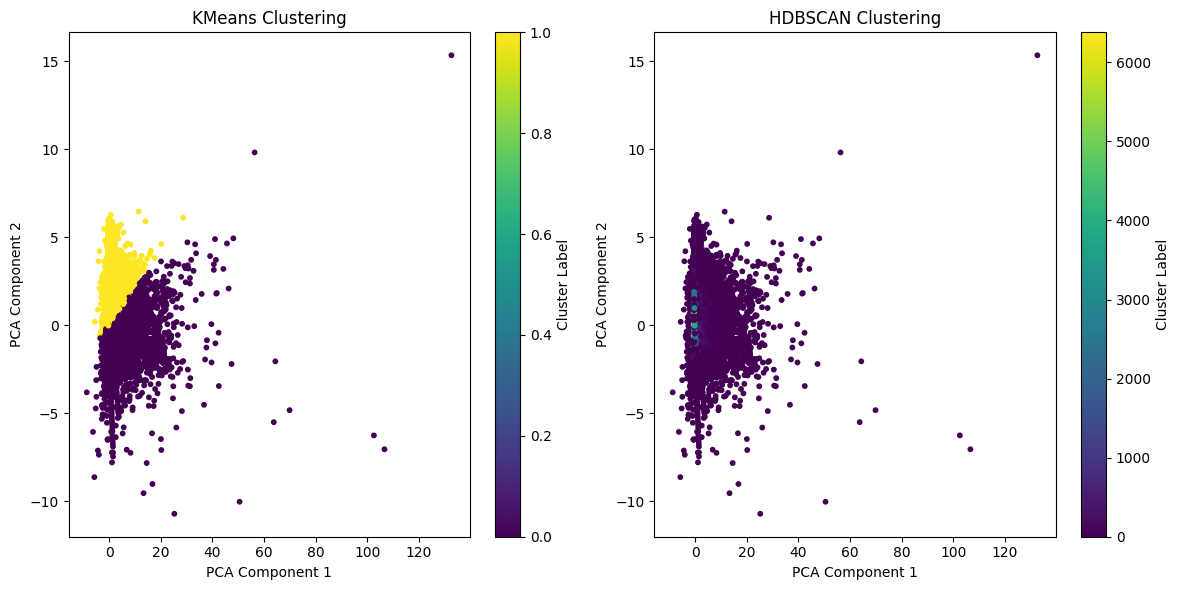

In [16]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=kmeans_labels, cmap='viridis', s=10)
plt.title("KMeans Clustering")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.colorbar(label='Cluster Label')
plt.subplot(1, 2, 2)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=dbscan_labels, cmap='viridis', s=10)
plt.title("HDBSCAN Clustering")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.colorbar(label='Cluster Label')
plt.tight_layout()
plt.show()


## Local Outlier Factor (LOF) for Anomaly Detection

In [13]:
lof = LocalOutlierFactor(n_neighbors=20, contamination=0.02)
lof_preds = lof.fit_predict(X_scaled)

# Map LOF output to 0 (normal) and 1 (anomaly)
lof_labels = np.where(lof_preds == -1, 1, 0)

## Evaluation of LOF

In [14]:
print("\n=== LOF Anomaly Detection ===")
print(classification_report(y, lof_labels, digits=4))


=== LOF Anomaly Detection ===
              precision    recall  f1-score   support

           0     0.9983    0.9800    0.9891    284314
           1     0.0030    0.0346    0.0055       492

    accuracy                         0.9784    284806
   macro avg     0.5006    0.5073    0.4973    284806
weighted avg     0.9966    0.9784    0.9874    284806



## Confusion Matrix

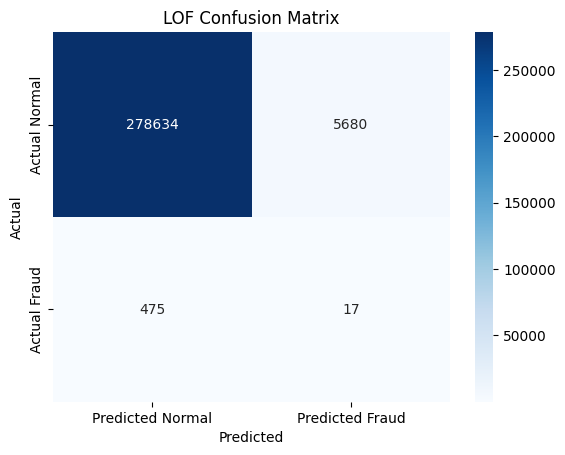

Text(0.5, 1.0, 'LOF Anomaly Detection')

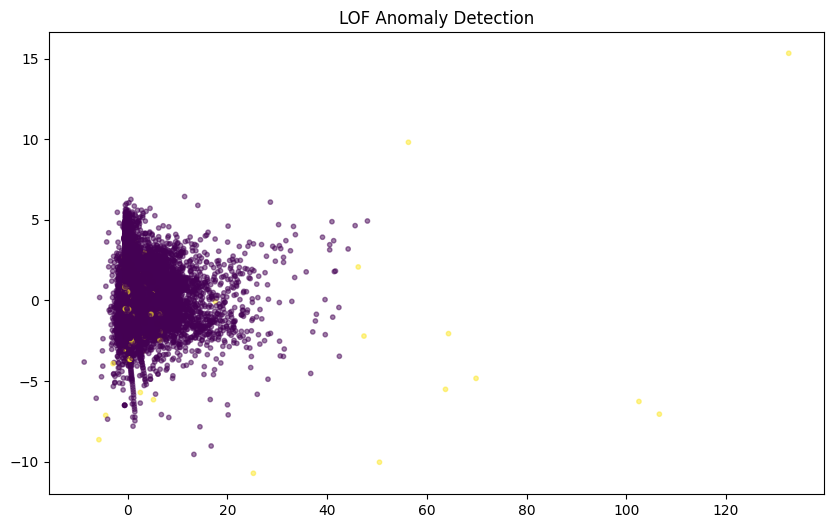

In [15]:
cm = confusion_matrix(y, lof_labels)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Predicted Normal", "Predicted Fraud"],
            yticklabels=["Actual Normal", "Actual Fraud"])
plt.title("LOF Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

plt.figure(figsize=(10, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=lof_labels, cmap='viridis', s=10, alpha=0.5)
plt.title("LOF Anomaly Detection")

## Assignment Questions

Use the code in this notebook to answer the following questions:

### **Conceptual Understanding**

1. What is the main difference between KMeans and HDBSCAN clustering? How do they handle cluster shapes and noise?
2. Why is PCA applied before clustering or anomaly detection in this notebook?
3. What are the limitations of using accuracy as a metric for fraud detection?

### **Code Analysis**

4. Modify the code to use 3 principal components instead of 2. Re-run KMeans and observe how ARI and Silhouette Score change. What do you conclude?
5. Tune the `min_cluster_size` and `min_samples` parameters in HDBSCAN. Which combination gives the best Silhouette Score?
6. Replace LOF with `IsolationForest`. Compare the results. Which performs better in terms of detecting fraud?

### **Practical Extension**

7. Using the original (30D) features instead of PCA-reduced data, apply DBSCAN. What challenges do you face?
8. Visualize the LOF scores on a scatterplot. Which clusters are more vulnerable to fraud?
